# Project: LSTM_module

LSTM을 활용한 보이스피싱 탐지 모듈 개발

## 순서
1. import: 필요한 모듈 import
2. 전처리: 학습에 필요한 데이터 전처리 수행
3. 모델링(model): 모델 정의
4. 컴파일(compile): 모델 생성
5. 학습(fit): 모델 학습

## 모듈 import

In [1]:
import os

import json
import pickle

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from collections import Counter

from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## 파일 이름 선언

필요 변수, 모델, 토큰 객체 등 파일 이름 선언

In [2]:
file_name = "LSTM_module_ver4.0"

## 데이터 셋 불러오기

빈 list 생성

In [3]:
spam_X = []
ham_X = []

노인남녀/일반남녀 대화 데이터 가져오기

In [4]:
path = '../../jsonDataset/dataset/'
path1 = os.listdir(path)
for a in path1:
    path2 = os.listdir(path+a)
    for b in path2:
        path3 = os.listdir(path+a+'/'+b)
        for c in path3:
            path4 = os.listdir(path+a+'/'+b+'/'+c)
            for d in path4:
                path5 = os.listdir(path+a+'/'+b+'/'+c+'/'+d)                    
                for e in path5:
                    path6 = path+a+'/'+b+'/'+c+'/'+d+'/'+e
                    with open(path6, "r", encoding="UTF-8") as f:
                        contents = f.read()
                        json_data = json.loads(contents)
                        data = ''
                        data = json_data['발화정보']['stt']
                        
                        if a == '자유대화 음성(노인남녀)':
                            spam_X.append(data) # 노인남녀
                        else:
                            ham_X.append(data) # 일반남녀

피싱 데이터 5개 출력

In [5]:
spam_X[:5]

['우리 자리는 관전하기에도 최선입니다',
 '우리 자리는 관전하기에도 최선입니다',
 '결국 주차 요금을 올릴 수밖에 없어요',
 '결국 주차 요금을 올릴 수밖에 없어요',
 '많이 세련됬구나 이런 느낌을 받았어 ']

일반 데이터 5개 출력

In [6]:
ham_X[:5]

['속상해 죽겠어',
 '큰 맘 먹고 산 명품 신발인데',
 '그러니까 말이야 장마가 원망스럽네 재녹음',
 '그리고 해가 나는 날이 별로 없으니',
 '(SP:그래 )물건 별로 말리는 방법이 달라']

## 전처리: 데이터 길이 제한

* `min_data`: 길이 min 사이즈를 지정함, min 미만의 데이터 삭제

In [7]:
min_data = 5

길이가 min 미만 데이터 삭제 후 중복 제거

In [27]:
spam_df = pd.DataFrame(spam_X, columns=['text'])
spam_df.drop(spam_df[spam_df['text'].str.len() < min_data].index, inplace=True) # 길이가 min_data 미만인 데이터 삭제
spam_df.shape[0] - spam_df['text'].nunique() # 중복 개수

37448

In [28]:
ham_df = pd.DataFrame(ham_X, columns=['text'])
ham_df.drop(ham_df[ham_df['text'].str.len() < min_data].index, inplace=True) # 길이가 min_data 미만인 데이터 삭제
ham_df.shape[0] - ham_df['text'].nunique() # 중복 개수

242555

In [9]:
spam_df.drop_duplicates(subset=['text'], inplace=True) # 중복 제거
spam_df['label'] = 1

In [11]:
ham_df.drop_duplicates(subset=['text'], inplace=True) # 중복 제거
ham_df['label'] = 0

데이터 정보 출력

In [12]:
print("스팸 데이터 개수 : {}(read) -> {}(drop)".format(len(spam_X),len(spam_df)))
print('스팸 데이터 최소 길이',len(min(spam_df['text'], key=len)))
print('스팸 데이터 최대 길이',len(max(spam_df['text'], key=len)))
print('----------------------------------------------------')
print("일반 데이터 개수 : {}(read) -> {}(drop)".format(len(ham_X),len(ham_df)))
print('일반 데이터 최소 길이',len(min(ham_df['text'], key=len)))
print('일반 데이터 최대 길이',len(max(ham_df['text'], key=len)))

스팸 데이터 개수 : 69305(read) -> 31840(drop)
스팸 데이터 최소 길이 5
스팸 데이터 최대 길이 149
----------------------------------------------------
일반 데이터 개수 : 359786(read) -> 115579(drop)
일반 데이터 최소 길이 5
일반 데이터 최대 길이 142


스팸 / 일반 데이터 합치기

In [13]:
total_df = pd.concat([spam_df, ham_df], ignore_index=True)

In [14]:
total_df

,text,label
0,우리 자리는 관전하기에도 최선입니다,1
1,결국 주차 요금을 올릴 수밖에 없어요,1
2,많이 세련됬구나 이런 느낌을 받았어,1
3,요새 스페인인나 이런 나라에 가면은,1
4,어른들도 그림책을 굉장히 좋아하거든 자기도 알지요,1
...,...,...
147414,음료수랑 커피도 있으니 후식 까지도 걱정이 없어요,0
147415,음식 잘 드시는 분들의 회식이 라면 이렇게 양이 무제한으로 나오는 곳을 가는 게 좋...,0
147416,예전에는 샤브샤브에 랍스터를 추가할 수도 있었던 걸로 기억하는데 안 간지 오래되서 ...,0
147417,빨리 다시 문을 (SP:열었으면) 좋겠어요 그러려면 코로나가 끝이 나야겠죠,0


## Train / Validation Set 분리

0.75 : 0.25 비율로 나누기

In [15]:
train_data, test_data = train_test_split(total_df, test_size = 0.25, random_state = 42) # 훈련용 테스트 데이터 나누기

훈련 / 테스트 데이터 개수 출력

In [16]:
print('데이터 총 개수 :',len(total_df))
print('훈련용 데이터 개수 :', len(train_data))
print('테스트용 데이터 개수 :', len(test_data))

데이터 총 개수 : 147419
훈련용 데이터 개수 : 110564
테스트용 데이터 개수 : 36855


스팸 / 일반 데이터 개수 그래프 비교

   label  count
0      0  86622
1      1  23942


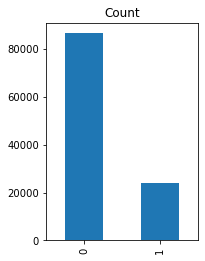

In [17]:
plt.subplot(121)
train_data['label'].value_counts().plot(kind = 'bar', title='Count')
print(train_data.groupby('label').size().reset_index(name = 'count'))

## 전처리: 특수문자 및 초성제거

한글과 공백을 제외하고 모두 제거

In [18]:
pd.set_option('mode.chained_assignment', None) # 경고 메시지 끄기

train_data['text'] = train_data['text'].str.replace("#@(.+?)#|[^가-힣 ]","",regex=True)
train_data.replace('', np.nan, inplace=True)

In [19]:
test_data['text'] = test_data['text'].str.replace("#@(.+?)#|[^가-힣 ]","",regex=True)
test_data.replace('', np.nan, inplace=True)

전처리 후 생긴 null 데이터 확인

In [20]:
print(train_data.isnull().sum()) # null 데이터 확인
print()
print(test_data.isnull().sum())

text     2
label    0
dtype: int64

text     1
label    0
dtype: int64


null 값이 있는 행 제거 후 확인

In [30]:
train_data = train_data.dropna(how='any', axis=0)
test_data = test_data.dropna(how='any', axis=0)

print(train_data.isnull().sum()) # null 데이터 확인
print()
print(test_data.isnull().sum())

text     0
label    0
dtype: int64

text     0
label    0
dtype: int64


## 전처리: 토큰화

Okt 객체 선언

In [21]:
okt = Okt() # 한글은 형태소 분석기 사용해야됨 KoNPLY

불용어 단어

In [22]:
stopwords = [,] # spam, ham 빈도 수 높은 중복단어 제거

어간 단위로 토큰화 및 불용어 처리

In [31]:
X_train = []
for sentence in train_data['text']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 처리
    X_train.append(temp_X)

In [32]:
X_test = []
for sentence in test_data['text']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 처리
    X_test.append(temp_X)

Dataframe 새 Column에 추가

In [33]:
train_data['tokenized'] = X_train
test_data['tokenized'] = X_test

## 단어별 빈도 수 확인

스팸 단어 빈도 확인

In [34]:
spam_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)
spam_word_count = Counter(spam_words)
print(spam_word_count.most_common(20))

[('을', 4883), ('있다', 3986), ('도', 3655), ('그', 3413), ('를', 3324), ('그렇다', 3271), ('들', 2731), ('은', 2699), ('가다', 2487), ('먹다', 2451), ('되다', 2415), ('거', 2409), ('같다', 2079), ('보다', 1941), ('안', 1869), ('것', 1806), ('우리', 1638), ('내', 1634), ('뭐', 1583), ('고', 1581)]


일상 단어 빈도 확인

In [35]:
ham_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
ham_word_count = Counter(ham_words)
print(ham_word_count.most_common(20))

[('을', 21013), ('있다', 15878), ('도', 12463), ('를', 12175), ('은', 11933), ('그렇다', 11708), ('것', 8891), ('보다', 8279), ('들', 8204), ('되다', 8177), ('같다', 7468), ('의', 7181), ('거', 6695), ('좋다', 6226), ('먹다', 5563), ('아니다', 5348), ('그', 4995), ('에서', 4904), ('않다', 4846), ('이다', 4567)]


Dataframe 값 추출

In [36]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test = test_data['tokenized'].values
y_test = test_data['label'].values

## 정수 인코딩

`vocab_size`의 값을 정하기 위한 토큰화 객체 생성

In [37]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

최소 단어 빈도 수 제한

In [38]:
threshold = 2 # 등장 횟수가 threshold이하인 단어는 제거

최적의 `vocab_size` 선정

In [39]:
word_to_index = tokenizer.word_index
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
        
print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

vocab_size = total_cnt - rare_cnt + 2
print('vocab_size :',vocab_size)

단어 집합(vocabulary)의 크기 : 25579
등장 빈도가 1번 이하인 희귀 단어의 수: 7785
단어 집합에서 희귀 단어의 비율: 30.435122561476213
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 0.6967415585531403
vocab_size : 17796


단어 토큰화
* `num_words`: 단어 max 사이즈 지정. 빈도수가 높은 순으로 저장.
* `oov_token`: 단어 토큰에 없는 단어 표기법 지정

In [40]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token = 'OOV')

`fit_on_texts`로 학습할 문장에 대한 토큰화 진행

In [41]:
tokenizer.fit_on_texts(X_train)

In [42]:
for key, value in tokenizer.word_index.items():
    print('{} \t======>\t {}'.format(key, value))
    if value == 25:
        break

OOV 	======>	 1
을 	======>	 2
있다 	======>	 3
도 	======>	 4
를 	======>	 5
그렇다 	======>	 6
은 	======>	 7
들 	======>	 8
것 	======>	 9
되다 	======>	 10
보다 	======>	 11
같다 	======>	 12
거 	======>	 13
그 	======>	 14
의 	======>	 15
먹다 	======>	 16
좋다 	======>	 17
아니다 	======>	 18
안 	======>	 19
에서 	======>	 20
가다 	======>	 21
나 	======>	 22
않다 	======>	 23
으로 	======>	 24
사람 	======>	 25


토큰화된 단어 사전의 개수

In [43]:
len(tokenizer.word_index)

25580

문장을 토큰으로 치환

In [44]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

변환된 Sequences 확인

In [45]:
X_train[:5]

[[120,
  170,
  38,
  14,
  1979,
  15,
  1572,
  1146,
  11003,
  8376,
  5892,
  1702,
  2,
  326,
  30,
  3,
  95,
  1172,
  2,
  464,
  20,
  2548,
  11,
  10,
  64],
 [6174, 8, 4, 2010, 15, 7303, 24, 2471],
 [367, 2828, 7, 802, 1834, 612, 39, 3892, 331, 26, 17, 184, 82, 87],
 [66, 38, 180, 743, 410, 52, 482, 139, 2188, 5, 950],
 [4803,
  116,
  7801,
  2,
  1373,
  5893,
  2,
  12460,
  1173,
  2,
  439,
  133,
  452,
  395,
  1,
  1737,
  24,
  1029,
  2,
  1034]]

`vocab_size`보다 떨어지는 단어는 1로 치환 (OOV)

## 패딩
리뷰 길이

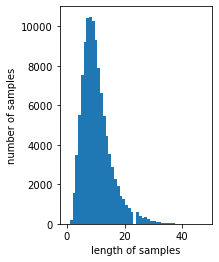

최대 길이 : 48
평균 길이 : 10.106040049926738


In [46]:
plt.subplot(122)
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

print('최대 길이 :',max(len(l) for l in X_train))
print('평균 길이 :',sum(map(len, X_train))/len(X_train))

3가지 옵션 입력
* `maxlen`: 최대 문장 길이 정의. 길면 잘라냄
* `truncating`: 문장 길이가 `maxlen`보다 길 때, 앞을 자를지 뒤를 자를지 정의
* `padding`: 문장 길이가 `maxlen`보다 짧을 때, 앞을 채울지 뒤를 채울지 정의

In [47]:
max_len = 40 # 최대 길이 (그래프를 보고 판단)
trunc_type = 'post' # 잘라낼 문장의 위치
padding_type = 'post'

문장 길이 비율 찾기

In [48]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))
    
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 99.97105696351369


In [49]:
X_train = pad_sequences(X_train, maxlen = max_len, truncating = trunc_type, padding = padding_type)
X_test = pad_sequences(X_test, maxlen = max_len, truncating = trunc_type, padding = padding_type)

변화된 후 shape 확인

In [50]:
X_train.shape

(110562, 40)

## 모델 정의

임베딩 차원 정의

In [51]:
embedding_dim = 16

모델 구성

In [52]:
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length = max_len),
    LSTM(64),
    Dense(1, activation='sigmoid')
])

## 컴파일

1. `optimizer`은 가장 최적화가 잘되는 알고리즘 'adam' 사용
2. `loss`는 이진분류이므로, `binary_crossentropy` 사용

In [53]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

## ModelCheckpoint

val_acc 기준으로 epoch 마다 최적의 모델을 저장하기 위한 체크포인트 설정

In [54]:
mc = ModelCheckpoint(file_name+'.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

## EarlyStopping

val_loss 기준으로 4번까지 Overfitting(과적합)이 진행되면 자동으로 종료

In [55]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

## 모델 학습

In [56]:
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
346/346 [==============================] - ETA: 0s - loss: 0.4417 - acc: 0.8210
Epoch 00001: val_acc improved from -inf to 0.86447, saving model to LSTM_module_ver4.0.h5
346/346 [==============================] - 13s 38ms/step - loss: 0.4417 - acc: 0.8210 - val_loss: 0.3333 - val_acc: 0.8645
Epoch 2/15
345/346 [============================>.] - ETA: 0s - loss: 0.2956 - acc: 0.8833
Epoch 00002: val_acc improved from 0.86447 to 0.87523, saving model to LSTM_module_ver4.0.h5
346/346 [==============================] - 12s 35ms/step - loss: 0.2955 - acc: 0.8834 - val_loss: 0.3120 - val_acc: 0.8752
Epoch 3/15
345/346 [============================>.] - ETA: 0s - loss: 0.2589 - acc: 0.8984
Epoch 00003: val_acc improved from 0.87523 to 0.87849, saving model to LSTM_module_ver4.0.h5
346/346 [==============================] - 12s 34ms/step - loss: 0.2589 - acc: 0.8984 - val_loss: 0.3077 - val_acc: 0.8785
Epoch 4/15
346/346 [==============================] - ETA: 0s - loss: 0.2420 - acc

학습 완료 후 `load_model` 를 해주지 않으면 ModelCheckpoint를 만든 의미가 없음

In [57]:
model = load_model(file_name+'.h5')

## 학습 오차 시각화

1152/1152 [==============================] - 3s 3ms/step - loss: 0.3327 - acc: 0.8834

 테스트 정확도: 0.8834


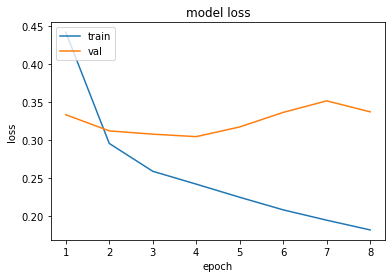

In [58]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

## 파일 저장

tokenizer 객체 저장

In [59]:
with open(file_name+"_tokenizer.pickle", "wb") as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

변수 저장

In [60]:
d = {'min_data':min_data, 'max_len':max_len, 'trunc_type':trunc_type, 'padding_type':padding_type}
json_var = json.dumps(d)
with open(file_name+'_variable.json', 'w') as f:
    f.write(json_var)

불용어 단어 저장

In [61]:
json_stopwords = json.dumps(stopwords)
with open(file_name+'_stopwords.json', 'w') as f:
    f.write(json_stopwords)